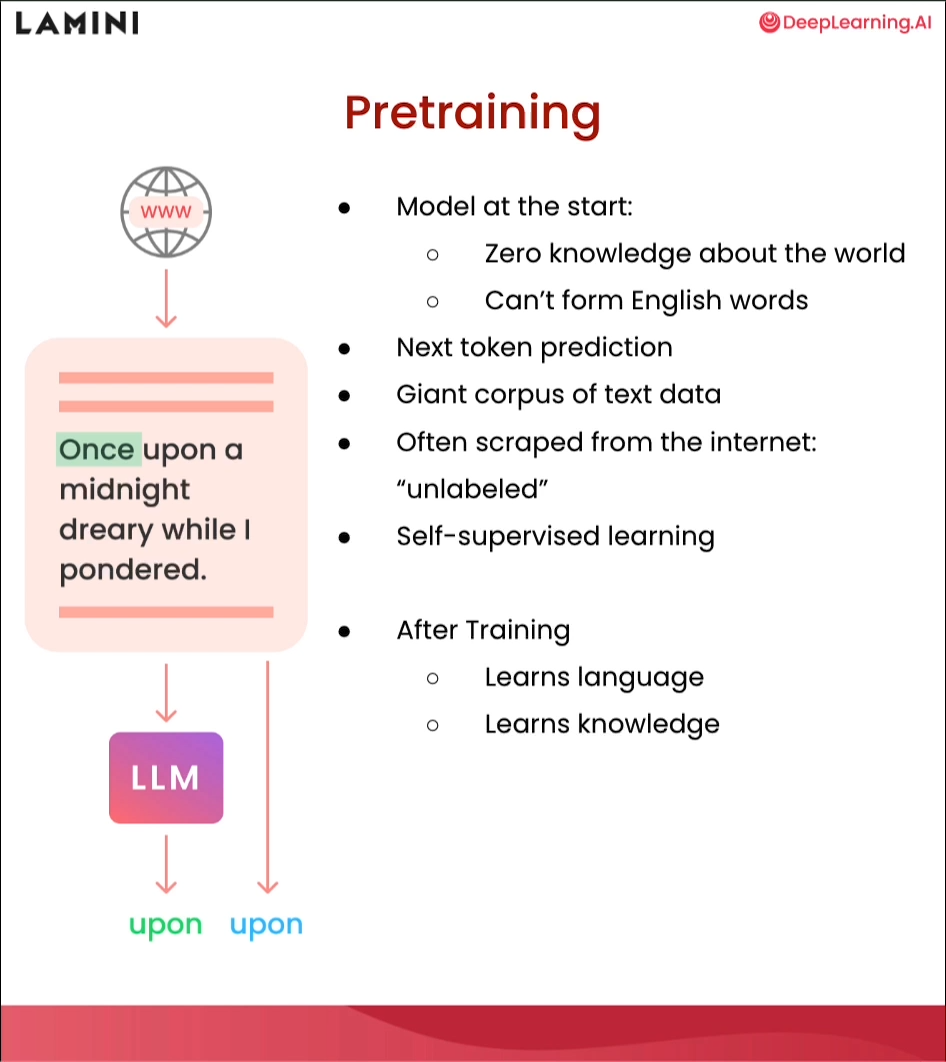

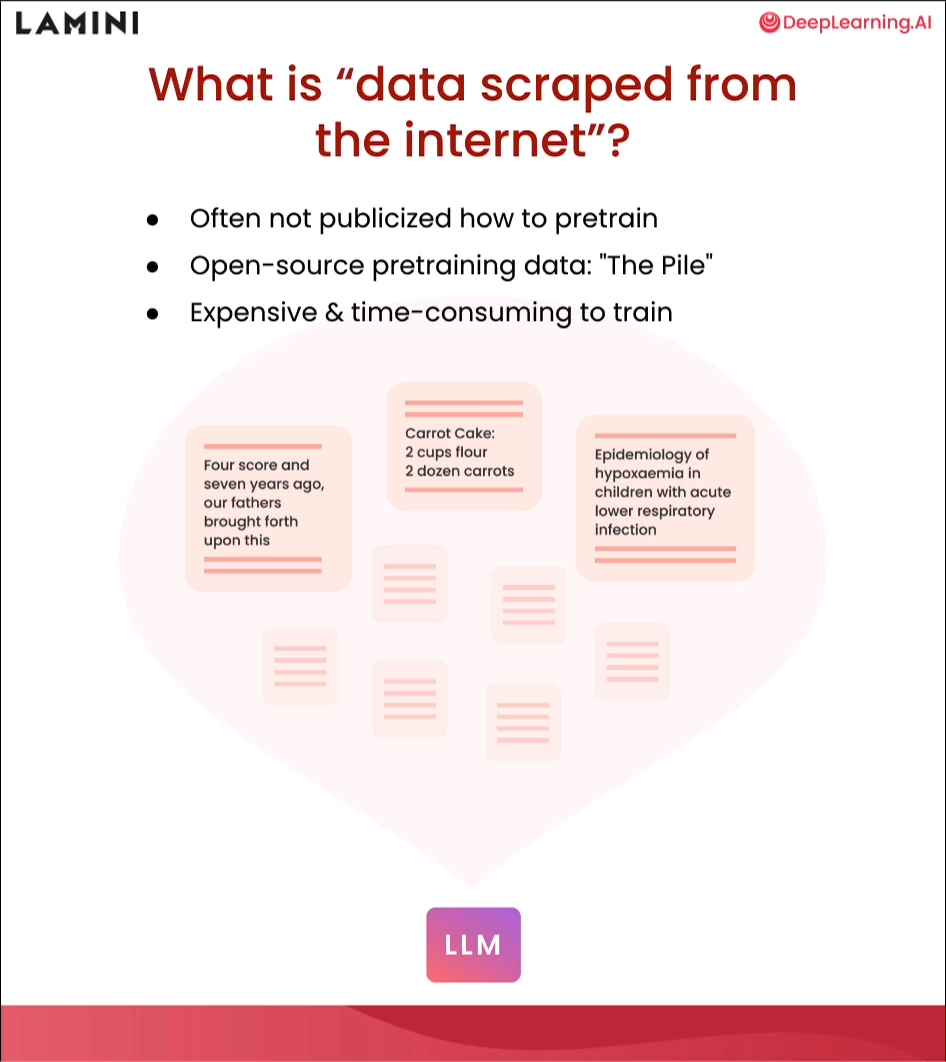

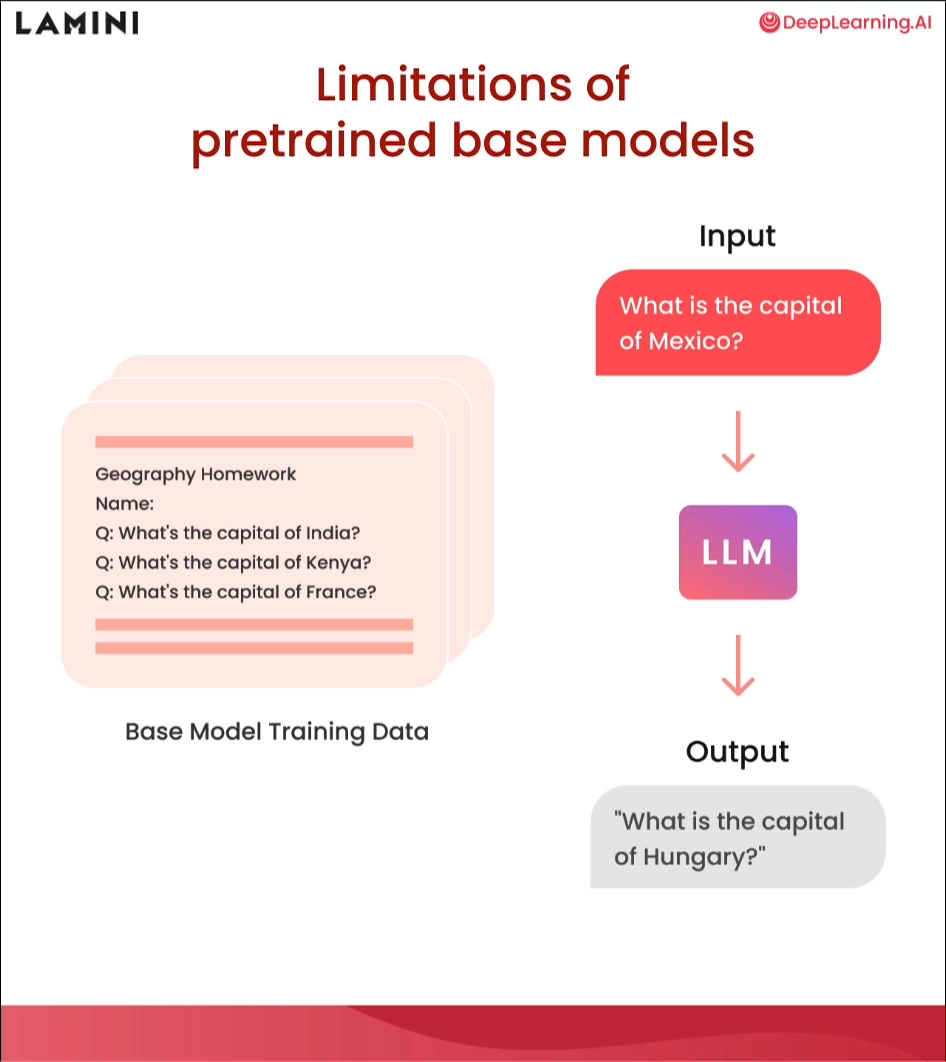

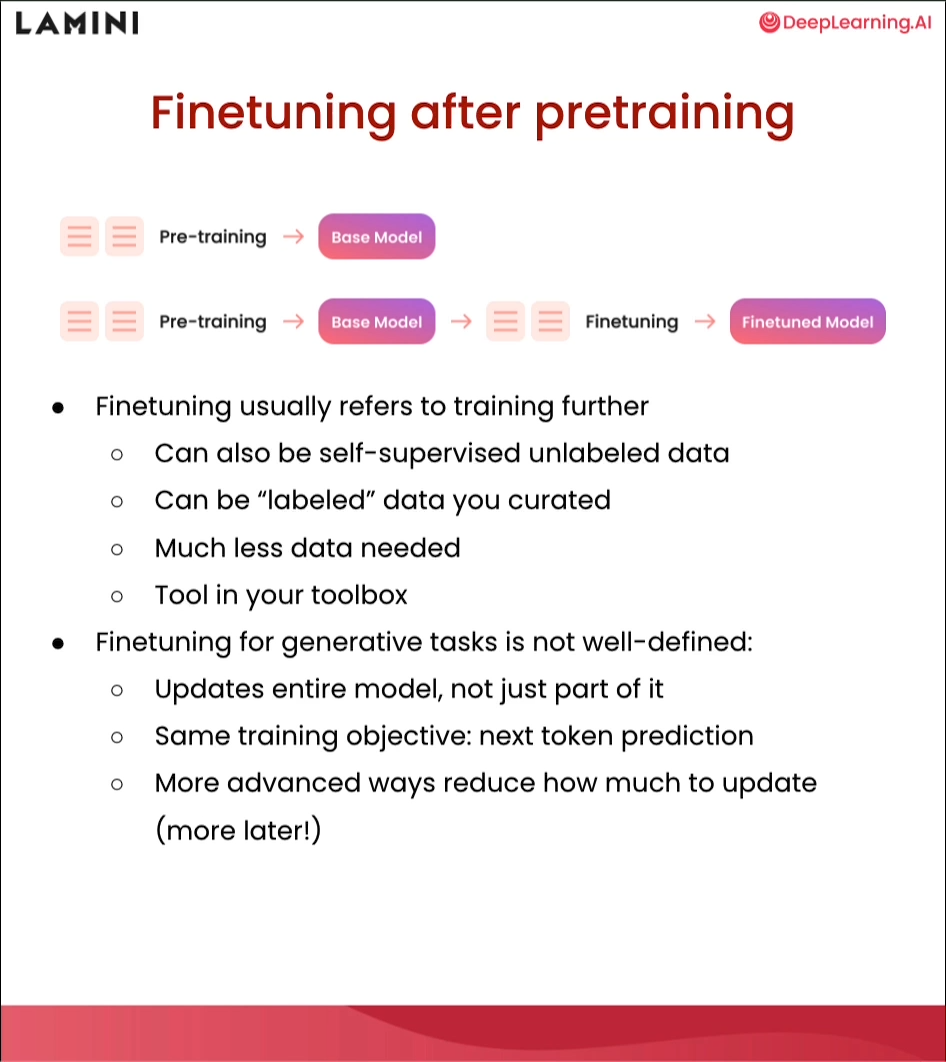

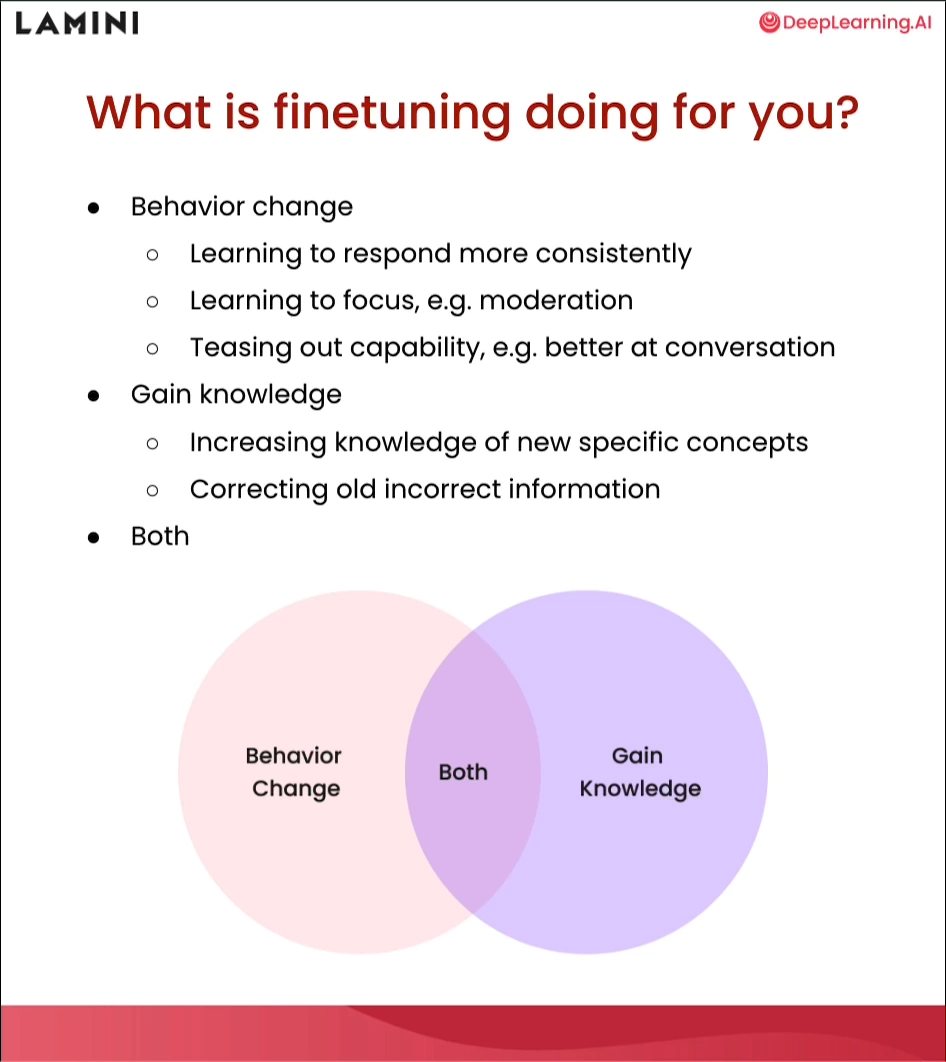

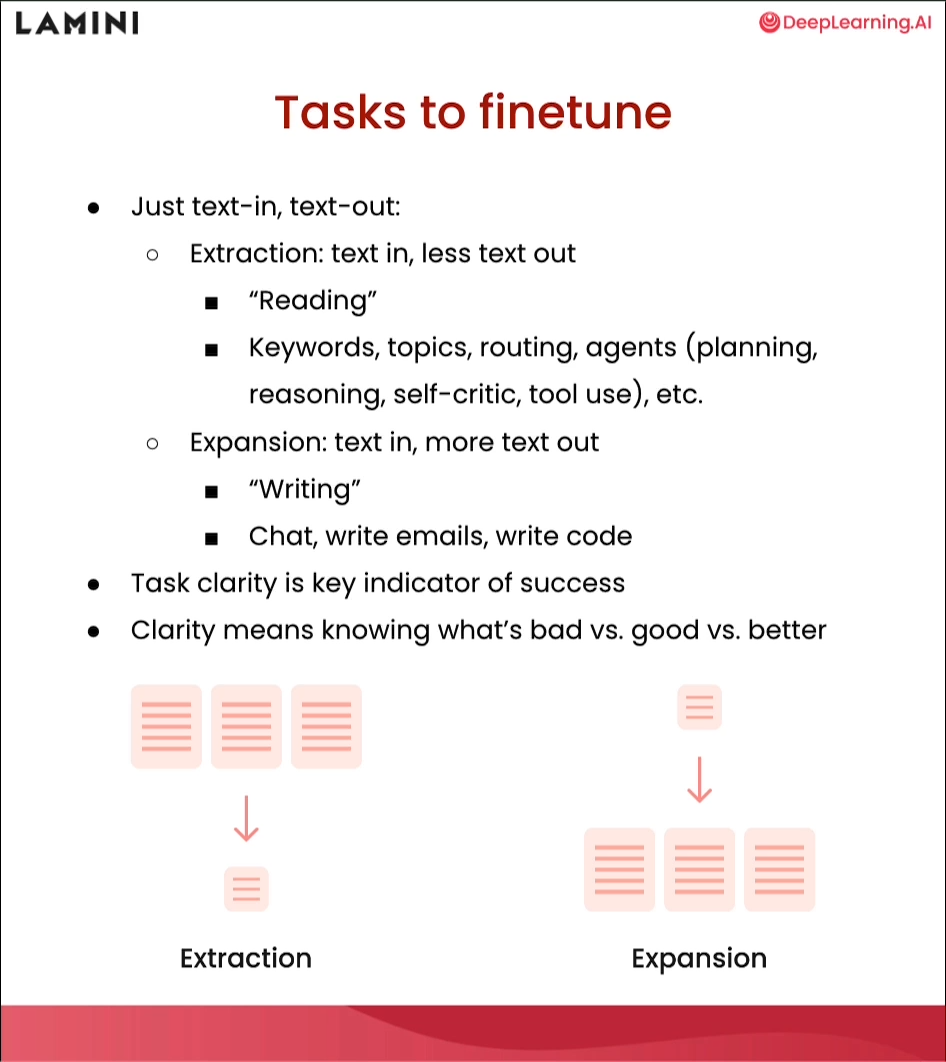

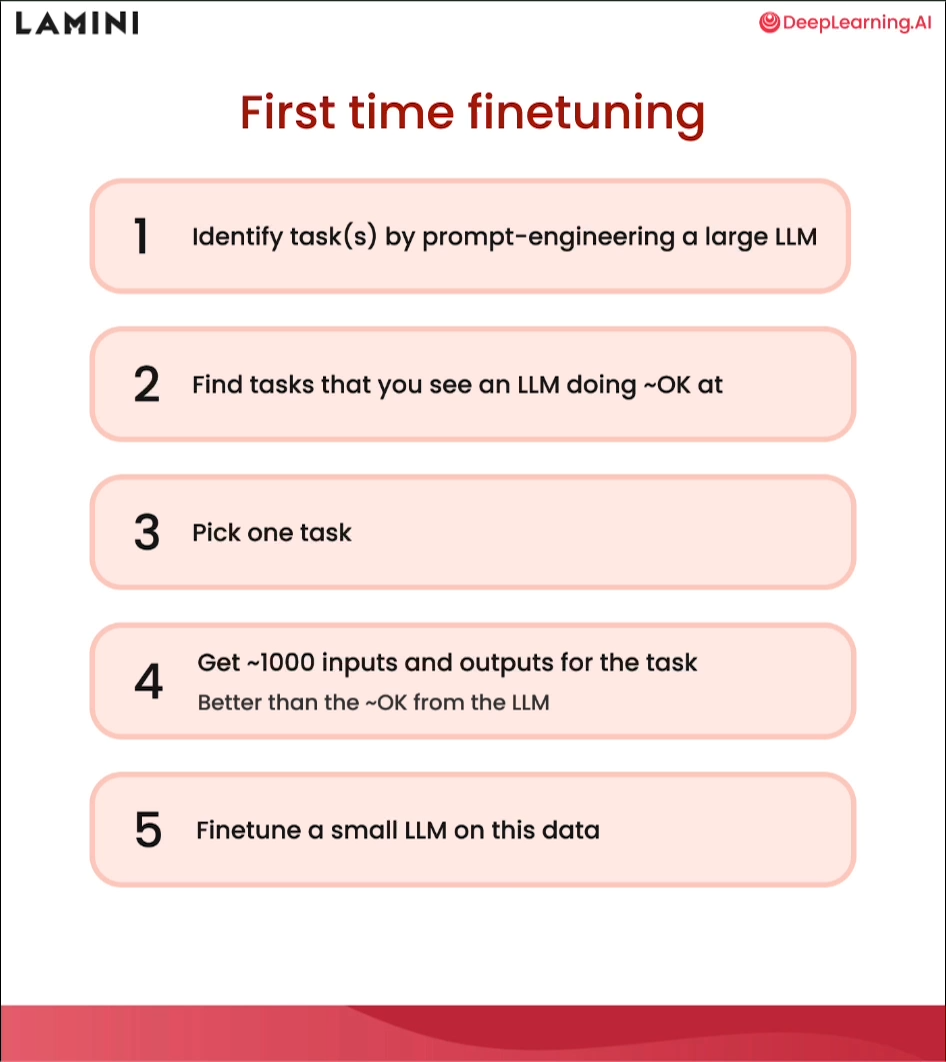

# Finetuning data: compare to pretraining and basic preparation

In [1]:
import jsonlines
import itertools
import pandas as pd
from pprint import pprint

import datasets
from datasets import load_dataset

### Look at pretraining data set

**Sorry**, "The Pile" dataset is currently relocating to a new home and so we can't show you the same example that is in the video. Here is another dataset, the ["Common Crawl"](https://huggingface.co/datasets/c4) dataset.

In [2]:
#pretrained_dataset = load_dataset("EleutherAI/pile", split="train", streaming=True)

pretrained_dataset = load_dataset("c4", "en", split="train", streaming=True)


/home/jovyan/.cache/huggingface/modules/datasets_modules/datasets/c4/584d57ebe81c209b6c7f31727066d2c4b4bba37cb7092cdd83083d5ec11207db/c4.py:53: FutureWarning: Dataset 'c4' is deprecated and will be deleted. Use 'allenai/c4' instead.
  warnings.warn(


In [3]:
n = 5
print("Pretrained dataset:")
top_n = itertools.islice(pretrained_dataset, n)
for i in top_n:
  print(i)

Pretrained dataset:
{'text': 'Beginners BBQ Class Taking Place in Missoula!\nDo you want to get better at making delicious BBQ? You will have the opportunity, put this on your calendar now. Thursday, September 22nd join World Class BBQ Champion, Tony Balay from Lonestar Smoke Rangers. He will be teaching a beginner level class for everyone who wants to get better with their culinary skills.\nHe will teach you everything you need to know to compete in a KCBS BBQ competition, including techniques, recipes, timelines, meat selection and trimming, plus smoker and fire information.\nThe cost to be in the class is $35 per person, and for spectators it is free. Included in the cost will be either a t-shirt or apron and you will be tasting samples of each meat that is prepared.', 'timestamp': '2019-04-25T12:57:54Z', 'url': 'https://klyq.com/beginners-bbq-class-taking-place-in-missoula/'}
{'text': 'Discussion in \'Mac OS X Lion (10.7)\' started by axboi87, Jan 20, 2012.\nI\'ve got a 500gb inter

### Contrast with company finetuning dataset you will be using

In [4]:
filename = "lamini_docs.jsonl"
instruction_dataset_df = pd.read_json(filename, lines=True)
instruction_dataset_df

,question,answer
0,What are the different types of documents avai...,"Lamini has documentation on Getting Started, A..."
1,What is the recommended way to set up and conf...,Lamini can be downloaded as a python package a...
2,How can I find the specific documentation I ne...,"You can ask this model about documentation, wh..."
3,Does the documentation include explanations of...,Our documentation provides both real-world and...
4,Does the documentation provide information abo...,External dependencies and libraries are all av...
...,...,...
1395,What is Lamini and what is its collaboration w...,Lamini is a library that simplifies the proces...
1396,How does Lamini simplify the process of access...,Lamini simplifies data access in Databricks by...
1397,What are some of the key features provided by ...,Lamini automatically manages the infrastructur...
1398,How does Lamini ensure data privacy during the...,"During the training process, Lamini ensures da..."


### Various ways of formatting your data

In [5]:
examples = instruction_dataset_df.to_dict()
text = examples["question"][0] + examples["answer"][0]
text

"What are the different types of documents available in the repository (e.g., installation guide, API documentation, developer's guide)?Lamini has documentation on Getting Started, Authentication, Question Answer Model, Python Library, Batching, Error Handling, Advanced topics, and class documentation on LLM Engine available at https://lamini-ai.github.io/."

In [6]:
if "question" in examples and "answer" in examples:
  text = examples["question"][0] + examples["answer"][0]
elif "instruction" in examples and "response" in examples:
  text = examples["instruction"][0] + examples["response"][0]
elif "input" in examples and "output" in examples:
  text = examples["input"][0] + examples["output"][0]
else:
  text = examples["text"][0]

In [7]:
prompt_template_qa = """### Question:
{question}

### Answer:
{answer}"""

In [8]:
question = examples["question"][0]
answer = examples["answer"][0]

text_with_prompt_template = prompt_template_qa.format(question=question, answer=answer)
text_with_prompt_template

"### Question:\nWhat are the different types of documents available in the repository (e.g., installation guide, API documentation, developer's guide)?\n\n### Answer:\nLamini has documentation on Getting Started, Authentication, Question Answer Model, Python Library, Batching, Error Handling, Advanced topics, and class documentation on LLM Engine available at https://lamini-ai.github.io/."

In [9]:
prompt_template_q = """### Question:
{question}

### Answer:"""

In [10]:
num_examples = len(examples["question"])
finetuning_dataset_text_only = []
finetuning_dataset_question_answer = []
for i in range(num_examples):
  question = examples["question"][i]
  answer = examples["answer"][i]

  text_with_prompt_template_qa = prompt_template_qa.format(question=question, answer=answer)
  finetuning_dataset_text_only.append({"text": text_with_prompt_template_qa})

  text_with_prompt_template_q = prompt_template_q.format(question=question)
  finetuning_dataset_question_answer.append({"question": text_with_prompt_template_q, "answer": answer})

In [11]:
pprint(finetuning_dataset_text_only[0])

{'text': '### Question:\n'
         'What are the different types of documents available in the '
         "repository (e.g., installation guide, API documentation, developer's "
         'guide)?\n'
         '\n'
         '### Answer:\n'
         'Lamini has documentation on Getting Started, Authentication, '
         'Question Answer Model, Python Library, Batching, Error Handling, '
         'Advanced topics, and class documentation on LLM Engine available at '
         'https://lamini-ai.github.io/.'}


In [12]:
pprint(finetuning_dataset_question_answer[0])

{'answer': 'Lamini has documentation on Getting Started, Authentication, '
           'Question Answer Model, Python Library, Batching, Error Handling, '
           'Advanced topics, and class documentation on LLM Engine available '
           'at https://lamini-ai.github.io/.',
 'question': '### Question:\n'
             'What are the different types of documents available in the '
             'repository (e.g., installation guide, API documentation, '
             "developer's guide)?\n"
             '\n'
             '### Answer:'}


### Common ways of storing your data

In [13]:
with jsonlines.open(f'lamini_docs_processed.jsonl', 'w') as writer:
    writer.write_all(finetuning_dataset_question_answer)

In [14]:
finetuning_dataset_name = "lamini/lamini_docs"
finetuning_dataset = load_dataset(finetuning_dataset_name)
print(finetuning_dataset)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1260 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/140 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1260
    })
    test: Dataset({
        features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 140
    })
})
